In [5]:
using Flux
using Flux: onehot, onecold, logitcrossentropy, onehotbatch, crossentropy
using MLDatasets
using Random
using Statistics
using MLJBase
using BSON: @load # for load weights
using BSON: @save # for load weights
using Plots
using DelimitedFiles
using Zygote
import JLD2

Load in data 

In [6]:
train_data = JLD2.load_object("data/train_data.jld2");
test_data = JLD2.load_object("data/test_data.jld2");
x_train = JLD2.load_object("data/x_train.jld2");
y_train = JLD2.load_object("data/y_train.jld2");
x_test  = JLD2.load_object("data/x_test.jld2");
y_test  = JLD2.load_object("data/y_test.jld2");

In [7]:
accuracy(model,x,y) = sum(onecold(model(x)) .== onecold(y))/size(x,2)
accuracy(xy, model) = mean( onecold(model(x)) .== onecold(y) for (x,y) in xy)
loss(model) = (x,y)->logitcrossentropy(model(x), y)
loss(model,x,y) = loss(model)(x, y)
loss(xy, model) = loss(model)(hcat(map(first,xy)...), hcat(map(last,xy)...))

loss (generic function with 3 methods)

In [8]:
epochs = 10 # the number of epochs
# change population_size will increase training time, but may increase the accuracy
save_resultTest = zeros(epochs);
save_resultTrain = zeros(epochs);
# l1 = Dense(19, 2*19, sigmoid)
# l2 = Dense(2*19, 2)
model = Chain(Dense(19, 2*19, sigmoid), Dense(2*19, 2))#define the model 


for j in 1:epochs
    Flux.train!(loss(model), Flux.params(model), train_data, ADAM(1e-4))
    save_resultTest[j] = save_resultTest[j] + accuracy(test_data, model)
    save_resultTrain[j] = save_resultTrain[j] + accuracy(train_data, model)
end


In [9]:
# save_resultTrain= JLD2.load_object("saveData.jld2");
# save_resultTest= JLD2.load_object("saveDatafin2.jld2");
@save "mymodel.bson" model

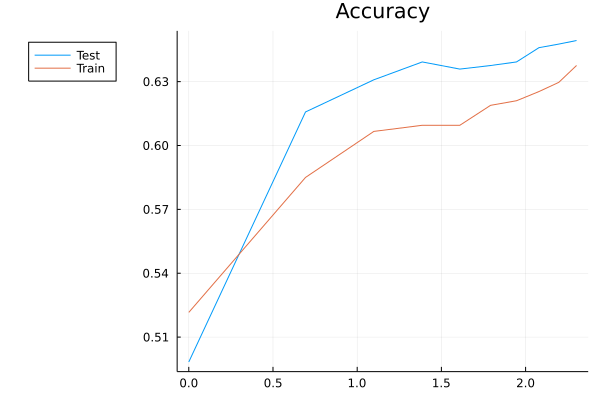

In [10]:
save_resultTest = save_resultTest ./ 1;
save_resultTrain = save_resultTrain ./ 1;

plot(log.(1:epochs), save_resultTest,label="Test")
plot!(log.(1:epochs), save_resultTrain,label = "Train", title = "Accuracy", legend = :outertopleft)

In [11]:
simplified_x_train_result = []
for i  = 1:size(x_train,2)
    if softmax(model(x_train[:,i]))[1]>0.5
        push!(simplified_x_train_result, 0)
    else
        push!(simplified_x_train_result, 1)
    end
end
simplified_y_train = []
for i  = 1:size(x_train,2)
    if y_train[i] == 0
        push!(simplified_y_train, 0)
    else
        push!(simplified_y_train, 1)
    end
end

# ConfusionMatrix for the training data
print("ConfusionMatrix for the training data\n")
ConfusionMatrix()(simplified_x_train_result, simplified_y_train)

ConfusionMatrix for the training data


┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\xkzmx\.julia\packages\MLJBase\pCiRR\src\measures\confusion_matrix.jl:112


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      0      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │     253     │     470     │
├─────────────┼─────────────┼─────────────┤
│      1      │     415     │     250     │
└─────────────┴─────────────┴─────────────┘


In [12]:
simplified_x_test_result = []
for i  = 1:size(x_test,2) 
    if softmax(model(x_test[:,i]))[1]>0.5
        push!(simplified_x_test_result, 0)
    else
        push!(simplified_x_test_result, 1)
    end
end
simplified_y_test = []
for i  = 1:size(x_test,2) 
    if y_test[i] == 0
        push!(simplified_y_test, 0)
    else
        push!(simplified_y_test, 1)
    end
end

# ConfusionMatrix for the test data
print("ConfusionMatrix for the test data\n")
ConfusionMatrix()(simplified_x_test_result, simplified_y_test)

ConfusionMatrix for the test data


┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\xkzmx\.julia\packages\MLJBase\pCiRR\src\measures\confusion_matrix.jl:112


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      0      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │     115     │     173     │
├─────────────┼─────────────┼─────────────┤
│      1      │     214     │     94      │
└─────────────┴─────────────┴─────────────┘
